In [28]:
import pandas as pd
import numpy as np
import re
import json
import ast
#pip install missingno
import missingno as msno

## 1.0 Dataset: Movies: 
#### 1.1 Lectura de archivos

In [29]:
df = pd.read_csv("../movies_dataset.csv")
print("dimensiones de la data:",df.shape)

dimensiones de la data: (45466, 24)


C:\Users\Pablo\AppData\Local\Temp\ipykernel_14568\2506349904.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../movies_dataset.csv")


### 1.1 valores nulos de la data

In [30]:
df.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

<AxesSubplot: >

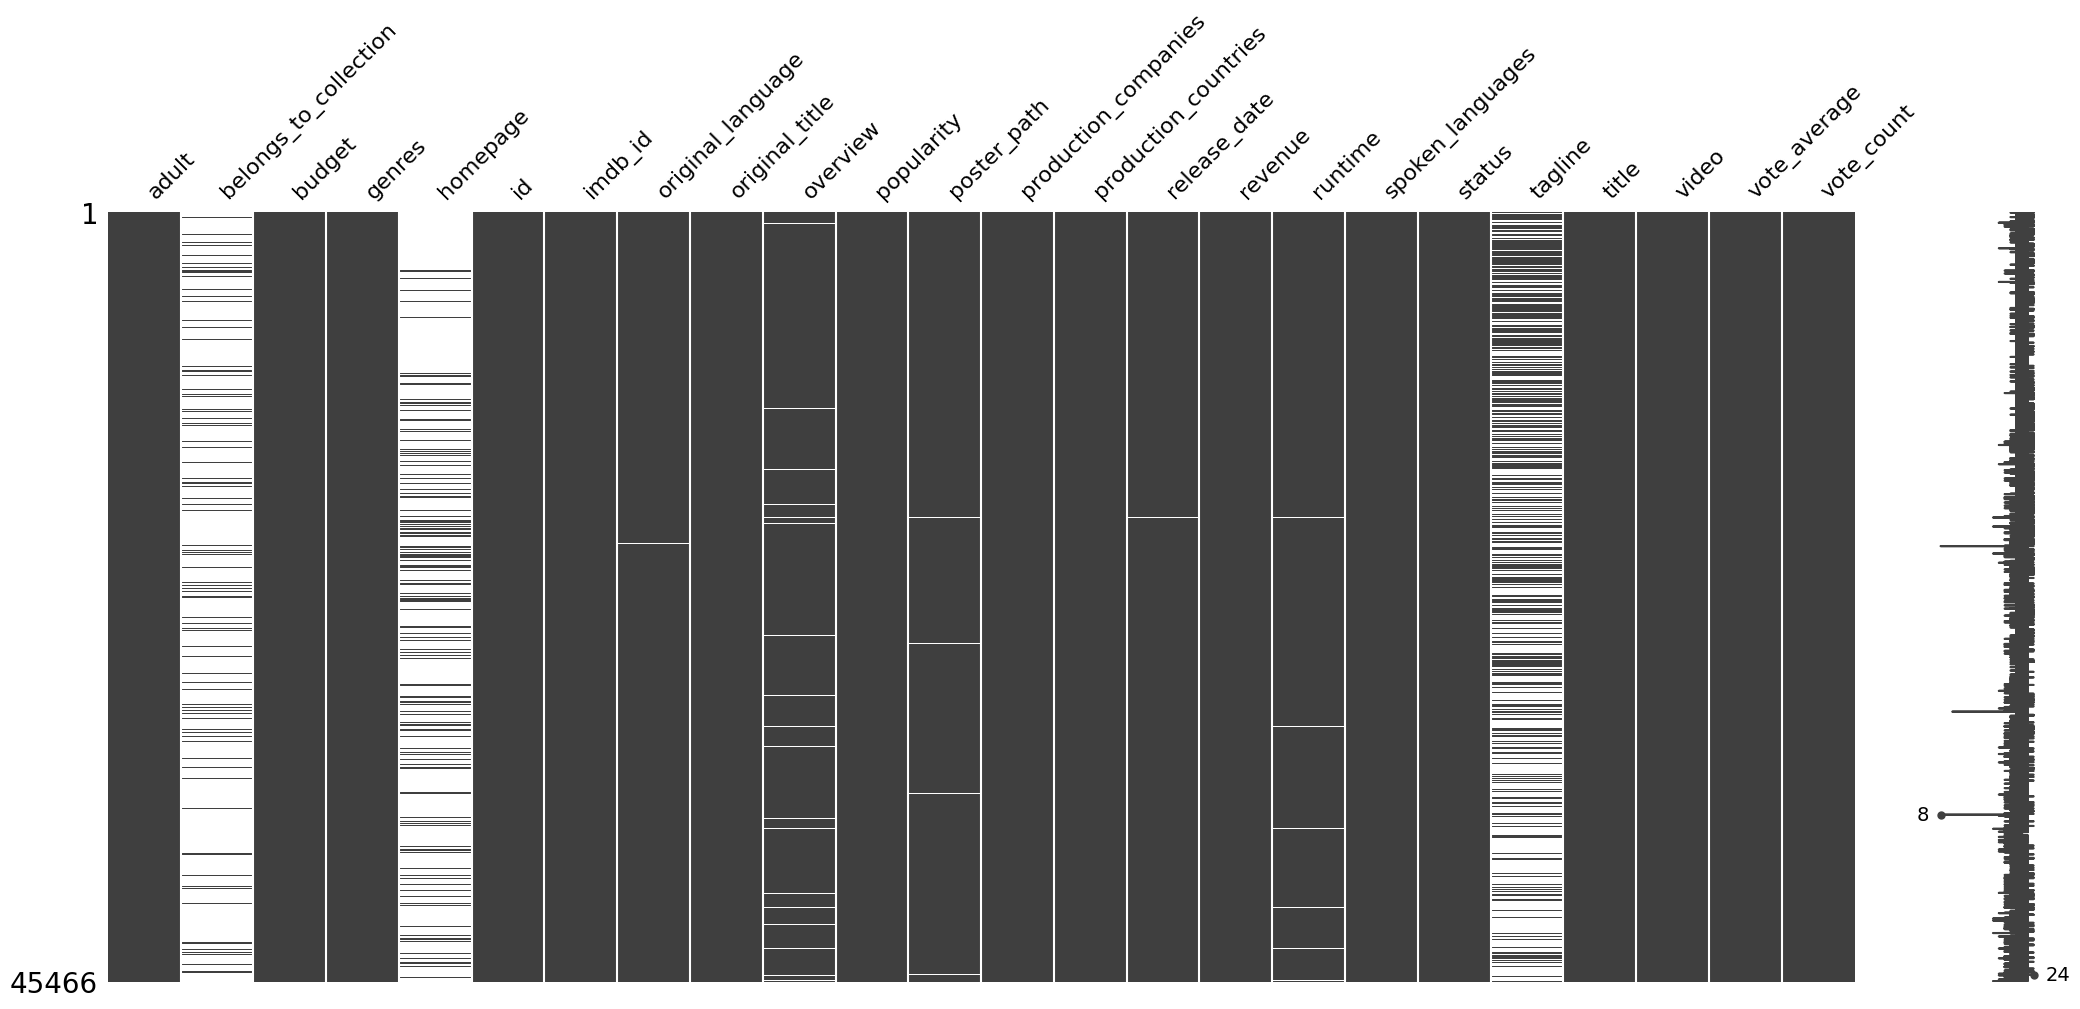

In [31]:
msno.matrix(df)

Debera considerarse que hacer con las columnas como belong_to_collection, homepage y tagline, que son las que tienen mayor cantidad de valores nulos.

#### 1.2 Tratamiento sobre columnas que sean colecciones

Para almacenar estos valores anidados, se procedera a guardarlos en una formato de lista de listas



In [32]:
df_diccts = df[['belongs_to_collection','genres','production_companies','production_countries','spoken_languages']] 

In [33]:
df_diccts.sample(3)

,belongs_to_collection,genres,production_companies,production_countries,spoken_languages
24446,NaN,"[{'id': 80, 'name': 'Crime'}, {'id': 99, 'name...",[],"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...","[{'iso_639_1': 'en', 'name': 'English'}, {'iso..."
4963,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...","[{'name': 'Atlas Entertainment', 'id': 507}, {...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso..."
31409,NaN,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...","[{'name': 'Addict Films', 'id': 69576}]","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...","[{'iso_639_1': 'no', 'name': 'Norsk'}]"


In [34]:
from Funciones import convertir_dicc_to_list #para estructuras como belong_to_collection
from Funciones import convertir_list_to_dicct # para estructuras como genres
from Funciones import convertir_str_list # para estructuras como spoken_lenguage

In [35]:
col1 =df['belongs_to_collection']
col2 =df['genres']
col3 =df['production_companies']
col4 =df['production_countries']
col5 =df['spoken_languages']

col1 = convertir_dicc_to_list(col1)
col2 = convertir_list_to_dicct(col2)
col3 = convertir_list_to_dicct(col3)
col4 = convertir_list_to_dicct(col4)
col5 = convertir_str_list(col5)


In [36]:
#reemplazar los valores de las columnas por estas nuevas listas
df['belongs_to_collection'] = pd.Series(col1)
df['genres'] = pd.Series(col2)
df['production_companies'] = pd.Series(col3)
df['production_countries'] = pd.Series(col4)
df['spoken_languages'] = pd.Series(col5)

In [37]:
df[['belongs_to_collection','genres','production_companies','production_countries','spoken_languages']].sample(5)

,belongs_to_collection,genres,production_companies,production_countries,spoken_languages
34975,NaN,"[[99, Documentary]]",NaN,NaN,NaN
41304,NaN,"[[18, Drama], [36, History]]",NaN,NaN,NaN
307,NaN,"[[27, Horror], [18, Drama]]","[[Allegro Films, 4899], [Norstar Entertainment...","[[CA, Canada]]","[[iso_639_1, en], [name, English]]"
3655,"[[id, 173628], [name, Nekromantik Collection],...","[[18, Drama], [27, Horror]]",[],"[[DE, Germany]]","[[iso_639_1, de], [name, Deutsch]]"
15959,NaN,"[[18, Drama], [35, Comedy]]",[],"[[IN, India]]","[[iso_639_1, hi], [name, हिन्दी], [iso_639_1, ..."


### 1.3 Requisitos de procesamiento de los datos

#### requisitos:

- 1.3.1 Los valores nulos de los campos revenue, budget deben ser rellenados por el número 0.

- 1.3.2 Los valores nulos del campo release date deben eliminarse.

- 1.3.3 De haber fechas, deberán tener el formato AAAA-mm-dd, además deberán crear la columna release_year donde extraerán el año de la fecha de estreno.

- 1.3.4 Crear la columna con el retorno de inversión, llamada return con los campos revenue y budget, dividiendo estas dos últimas revenue / budget, cuando no hay datos disponibles para calcularlo, deberá tomar el valor 0.

- 1.3.5 Eliminar las columnas que no serán utilizadas, video,imdb_id,adult,original_title,poster_path y homepage.

- 1.3.6 columna release_year con el año

- 1.3.7 convertir tipos de dato


In [38]:
# 1.3.1
df['revenue'].fillna(0,inplace=True)
df['budget'].fillna(0,inplace=True)
#1.3.2
df = df.dropna(axis=0,subset='release_date')
#1.3.3
df['release_date'] = pd.to_datetime(df['release_date'],errors='coerce')
df['release_year'] = df['release_date'].dt.year
#1.3.4
df['budget'] = pd.to_numeric(df['budget'],errors='coerce')
df['return'] = np.where((df['budget'].isna() | df['revenue'].isna() | (df['budget'] == 0)),
                     0, df['revenue'] / df['budget'])
#1.3.5
df = df.drop(columns= ['video','imdb_id','adult','original_title','poster_path','homepage'])
#1.3.6
df['release_year'] = df['release_date'].dt.year
# 1.3.7
df['id'] = pd.to_numeric(df['id'],errors='coerce')
df['popularity'] = pd.to_numeric(df['popularity'],errors='coerce')


## 2.0 Dataset: Credits

#### 2.1 Lectura del dataset: Credits

In [39]:
df_creditos = pd.read_csv("../credits.csv")

In [40]:
df_creditos.head(3)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602


#### 2.2 creacion de dataframes individuales para cast y crew

#### 2.2.1 df cast

In [41]:
linea_cast = df_creditos['cast']
linea_id = df_creditos['id']

## Para almacenar la informacion de cast, se procedera a crear un dataframe, donde cada "clave" sera una columna
## y cada "valor" sera una instancia, iterando sobre cada instancia de la columna cast,
## guardando el id, para que el nuevo dataframe tambien tenga el valor del id correspondiente de credits.
## Ademas de los valores del diccionario.
datos_cast = {}
datos_cast["id_credit"] = []
datos_cast["cast_id"] = []
datos_cast["character"] = []
datos_cast["credit_id"] = []
datos_cast["gender"] = []
datos_cast["id"] = []
datos_cast["name"] = []
datos_cast["order"] = []
datos_cast["profile_path"] = []
try:
    for idx, lis in enumerate(linea_cast):
        linea = ast.literal_eval(lis)
        id_actual = linea_id.iloc[idx]
        for dic in linea:
            datos_cast['id_credit'].append(id_actual)
            for clave,valor in dic.items():
                datos_cast[clave].append(valor)
except:
    pass

datos_cast = pd.DataFrame(datos_cast)

print(datos_cast.shape)
datos_cast.head()

(562474, 9)


,id_credit,cast_id,character,credit_id,gender,id,name,order,profile_path
0,862,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,862,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,862,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,862,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,862,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg


#### 2.2.2 df crew

In [42]:
linea_crew = df_creditos['crew']
linea_id = df_creditos['id']

datos_crew = {}
datos_crew["id_credit"] = []
datos_crew["credit_id"] = []
datos_crew["department"] = []
datos_crew["gender"] = []
datos_crew["id"] = []
datos_crew["job"] = []
datos_crew["name"] = []
datos_crew["profile_path"] = []
try:
    for idx, lis in enumerate(linea_crew):
        linea = ast.literal_eval(lis)
        id_actual = linea_id.iloc[idx]
        for dic in linea:
            datos_crew["id_credit"].append(id_actual)  # Agrega el id original repetido
            for clave, valor in dic.items():
                datos_crew[clave].append(valor)
except Exception as e:
    print(f"Ocurrió un error: {e}")

# Convertir a DataFrame para verificar los resultados
datos_crew = pd.DataFrame(datos_crew)
datos_crew.head()

,id_credit,credit_id,department,gender,id,job,name,profile_path
0,862,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,862,52fe4284c3a36847f8024f4f,Writing,2,12891,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,862,52fe4284c3a36847f8024f55,Writing,2,7,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg
3,862,52fe4284c3a36847f8024f5b,Writing,2,12892,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg
4,862,52fe4284c3a36847f8024f61,Writing,0,12893,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg


#### 3.0 Datasets: movies, cast y crew

In [43]:
print("dataset movies",df.shape)
print("dataset crew ",datos_crew.shape)
print("dataset cast",datos_cast.shape)

dataset movies (45379, 20)
dataset crew  (464314, 8)
dataset cast (562474, 9)


#### 3.1 Opcion a: cargar los datos como csv

In [44]:
#datos_cast.to_csv('df_cast.csv',index=False)
#datos_crew.to_csv('df_crew.csv',index=False)
#df.to_csv('movies.csv',index=False)

#### 3.1 Opcion b: transformar los tipos de datos anidados y almacenarlos en formato .parquet.

Debido a que parquet no soporta estrucutras anidadas de manera tan directa, se debera convertir los tipos de lista de listas a string de json sobre las columnas que tengan este tipo de estructura. Luego para desanidarlas se usara la misma funcion para convertirlos nuevamente a objetos de python

In [45]:
df['belongs_to_collection'] = df['belongs_to_collection'].apply(json.dumps)
df['genres'] = df['genres'].apply(json.dumps)
df['production_companies'] = df['production_companies'].apply(json.dumps)
df['production_countries'] = df['production_countries'].apply(json.dumps)
df['spoken_languages'] = df['spoken_languages'].apply(json.dumps)

#### 3.2 Recorte de los datasets
de la data "movies" se eliminaran las columnas de belongs_to_collection, production_companies, production_countries, spoken_languages y tagline	

de la data de credits:

crew: se eliminaran las columnas: credit_id, profile_path

cast: se eliminaran las columnas: credit_id, profile_path

In [46]:
df = df.drop(columns=['belongs_to_collection', 'production_companies', 'production_countries', 'spoken_languages', 'tagline'])
datos_crew = datos_crew.drop(columns=['credit_id'])
datos_cast = datos_cast.drop(columns=['credit_id'])
datos_cast = datos_cast.drop(columns=['profile_path'])
datos_crew = datos_crew.drop(columns=['profile_path'])


In [20]:
#df.to_parquet('data/df_movies_parquet.parquet',engine='pyarrow')
#datos_cast.to_parquet('data/df_cast_parquet.parquet',engine='pyarrow')
#datos_crew.to_parquet('data/df_crew_parquet.parquet',engine='pyarrow')

In [55]:
#ejemplo de lectura y des serializacion de 1 columna
df_leido = pd.read_parquet('data/df_movies_parquet.parquet', engine='pyarrow')
df_leido['genres'] = df_leido['genres'].apply(json.loads)
print(df_leido['genres'][0])
print(df_leido['genres'][0][1])
print(df_leido['genres'][0][1][1])

[[16, 'Animation'], [35, 'Comedy'], [10751, 'Family']]
[35, 'Comedy']
Comedy


In [61]:
for x in df['genres']:
    print(len(x))

54
55
36
51
16
64
36
69
53
53
51
32
57
32
35
30
35
31
50
47
49
33
68
76
35
15
50
35
62
30
30
63
39
67
52
15
70
55
51
15
31
63
35
33
66
35
52
72
35
48
49
36
35
70
15
2
51
51
52
55
33
52
16
36
16
42
34
36
16
65
54
51
32
35
35
42
21
33
33
34
30
31
35
2
35
31
54
16
48
15
69
52
51
68
16
15
94
21
33
46
36
78
16
35
50
88
21
15
64
30
65
33
15
16
56
46
36
31
85
15
36
51
35
36
17
15
2
36
31
51
73
51
39
16
21
16
15
2
35
16
15
51
65
69
30
51
64
15
19
31
48
35
33
16
32
52
49
113
49
21
49
52
34
62
30
70
19
64
51
94
26
31
30
31
53
31
54
36
97
51
38
34
83
16
16
51
48
15
52
21
15
31
16
58
15
74
35
18
32
35
16
34
50
21
35
35
15
33
15
85
15
31
35
16
33
31
34
68
54
16
51
87
18
53
48
52
49
16
51
34
69
48
36
51
69
93
33
51
32
51
81
64
21
32
35
53
50
34
51
36
35
31
55
68
97
64
61
35
51
15
30
35
70
54
31
30
35
15
48
77
51
51
36
51
36
31
30
31
33
30
64
16
60
35
48
51
15
53
75
48
51
51
33
15
31
35
32
32
32
33
31
31
54
52
50
15
56
31
31
19
51
34
61
67
30
33
33
31
31
51
16
51
75
50
79
49
35
60
16
35
33
31
35
75
5

## Finalizacion del proceso de Extraccion, Transformacion y Carga(Load) de los datos.